# Implementation

This section demonstrates how to fit bagging, random forest, and boosting models using `scikit-learn`.  We will again use the {doc}`penguins </content/appendix/data>` dataset for classification and the {doc}`tips </content/appendix/data>` dataset for regression.

In [11]:
## Import packages
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## 1. Bagging and Random Forests

Recall that bagging and random forests can handle both classification and regression tasks. For this example we will do classification on the `penguins` dataset.  Recall that `scikit-learn` trees do not currently support categorical predictors, so we must first convert those to dummy variables

In [17]:
## Load penguins data
penguins = sns.load_dataset('penguins')
penguins = penguins.dropna().reset_index(drop = True)
X = penguins.drop(columns = 'species')
y = penguins['species']

## Train-test split
np.random.seed(1)
test_frac = 0.25
test_size = int(len(y)*test_frac)
test_idxs = np.random.choice(np.arange(len(y)), test_size, replace = False)
X_train = X.drop(test_idxs)
y_train = y.drop(test_idxs)
X_test = X.loc[test_idxs]
y_test = y.loc[test_idxs]

## Get dummies
X_train = pd.get_dummies(X_train, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True)

### Bagging

A simple bagging classifier is fit below. The most important arguments are `n_estimators` and `base_estimator`, which determine the number and type of weak learners the bagging model should use. The default `base_estimator` is a decision tree, though this can be changed as in the second example below, which uses Naive Bayes estimators.  

In [52]:
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB

## Decision Tree bagger
bagger1 = BaggingClassifier(n_estimators = 50, random_state = 123)
bagger1.fit(X_train, y_train)

## Naive Bayes bagger
bagger2 = BaggingClassifier(base_estimator = GaussianNB(), random_state = 123)
bagger2.fit(X_train, y_train)

## Evaluate
print(np.mean(bagger1.predict(X_test) == y_test))
print(np.mean(bagger2.predict(X_test) == y_test))


0.963855421686747
0.9156626506024096


### Random Forests

An example of a random forest in `scikit-learn` is given below. The most important arguments to the random forest are the number of estimators (decision trees), `max_features` (the number of predictors to consider at each split), and any chosen parameters for the decision trees (such as the maximum depth). Guidelines for setting each of these parameters are given below. 

- `n_estimators`: In general, the more base estimators the better, though there are diminishing marginal returns. While increasing the number of base estimators does not risk overfitting, it eventually provides no benefit. 
- `max_features`: This argument is set by default to the square root of the number of total features (which is made explicit in the example below). If this value equals the number of total features, we are left with a bagging model. Lowering this value lowers the amount of correlation between trees but also prevents the base estimators from learning potentially valuable information. 
- Decision tree parameters: These parameters are generally left untouched. This allows the individual decision trees to grow deep, increasing variance but decreasing bias. The variance is then decreased by the ensemble of individual trees.


In [54]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, max_features = int(np.sqrt(X_test.shape[1])), random_state = 123)
rf.fit(X_train, y_train)
print(np.mean(rf.predict(X_test) == y_test))


0.9879518072289156


## 2. Boosting

```{note}
Note that the `AdaBoostClassifier` from `scikit-learn` uses a slightly different algorithm than the one introduced in the {doc}`concept section </content/c6/s1/boosting>` though results should be similar. The `AdaBoostRegressor` class in `scikit-learn` uses the same algorithm we introduced: *AdaBoost.R2*
```

### AdaBoost Classification

The `AdaBoostClassifier` in `scikit-learn` is actually able to handle multiclass target variables, but for consistency, let's use the same binary target we did in our AdaBoost construction: whether the penguin's species is *Adelie*.

In [3]:
## Make binary
y_train = (y_train == 'Adelie')
y_test = (y_test == 'Adelie')

We can then fit the classifier with the `AdaBoostClassifier` class as below. Again, we first convert categorical predictors to dummy variables. The classifier will by default use 50 decision trees, each with a max depth of 1, for the weak learners. 


In [4]:
from sklearn.ensemble import AdaBoostClassifier

## Get dummies
X_train = pd.get_dummies(X_train, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True)

## Build model
abc = AdaBoostClassifier(n_estimators = 50)
abc.fit(X_train, y_train)
y_test_hat = abc.predict(X_test)

## Evaluate 
np.mean(y_test_hat == y_test)

0.9759036144578314

A different weak learner can easily be used in place of a decision tree. The below shows an example using logistic regression. 

In [5]:
from sklearn.linear_model import LogisticRegression
abc = AdaBoostClassifier(base_estimator = LogisticRegression(max_iter = 1000))
abc.fit(X_train, y_train);

### AdaBoost Regression

AdaBoost regression is implemented almost identically in `scikit-learn`. An example with the `tips` dataset is shown below.

In [6]:
## Load penguins data
tips = sns.load_dataset('tips')
tips = tips.dropna().reset_index(drop = True)
X = tips.drop(columns = 'tip')
y = tips['tip']

## Train-test split
np.random.seed(1)
test_frac = 0.25
test_size = int(len(y)*test_frac)
test_idxs = np.random.choice(np.arange(len(y)), test_size, replace = False)
X_train = X.drop(test_idxs)
y_train = y.drop(test_idxs)
X_test = X.loc[test_idxs]
y_test = y.loc[test_idxs]

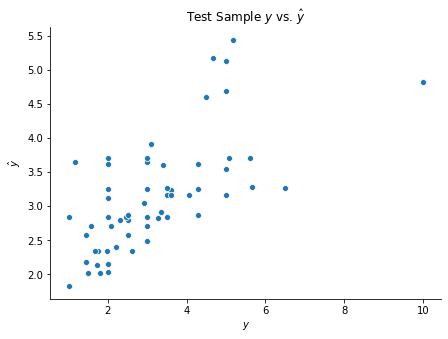

In [7]:
from sklearn.ensemble import AdaBoostRegressor

## Get dummies
X_train = pd.get_dummies(X_train, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True)

## Build model
abr = AdaBoostRegressor(n_estimators = 50)
abr.fit(X_train, y_train)
y_test_hat = abr.predict(X_test)

## Visualize predictions
fig, ax = plt.subplots(figsize = (7, 5))
sns.scatterplot(y_test, y_test_hat)
ax.set(xlabel = r'$y$', ylabel = r'$\hat{y}$', title = r'Test Sample $y$ vs. $\hat{y}$')
sns.despine()